# Capstone 3: Deep Neural Network Modeling & Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt

In [2]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [3]:
from keras.models import Sequential
from keras.layers import Dense

In [4]:
import tensorflow as ts

In [5]:
df_train = pd.read_csv('train.csv')

In [6]:
df_test = pd.read_csv('test.csv')

In [7]:
# off the bat we can drop the patients, and parents names, as well as the institue and the name of the institute as 
# this does not affect genetic outcome
df_train.drop(['Patient Id', 'Patient First Name', 'Family Name', "Father's name",
           'Institute Name', 'Institute Name', 'Location of Institute', 'Status', 'Place of birth','Test 1','Test 2','Test 3',
            'Test 4','Test 5'
           ], axis = 1, inplace = True)

train = df_train.rename(columns = {'Patient Age':'Patient_Age', "Genes in mother's side":"Genes_in_mothers_side",
            'Inherited from father':'Inherited_from_father',
            'Maternal gene':'Maternal_gene', 'Paternal gene':'Paternal_gene',
            'Blood cell count (mcL) ':'Blood_cell_count', "Father's age":'Fathers_age', "Mother's age":'Mothers_age',
            'Respiratory Rate (breaths/min)':'Respiratory_Rate', 'Heart Rate (rates/min)':'Heart_Rate',
            'Test 1':'Test_1', 'Test 2':'Test_2', 'Test 3':'Test_3',
            'Test 4':'Test_4', 'Test 5':'Test_5', 'Parental consent': 'Parental_consent', 'Follow-up':'Follow_up', 
             'Birth asphyxia':'Birth_asphyxia',
             'Autopsy shows birth defect (if applicable)': 'Autopsy_shows_birth_defect', 
             'Folic acid details (peri-conceptional)':'Folic_acid_details', 
            'H/O serious maternal illness':'HO_serious_maternal_illness',
            'H/O radiation exposure (x-ray)':'HO_radiation_exposure', 'H/O substance abuse':'HO_substance_abuse',
            'Assisted conception IVF/ART':'Assisted_conception_IVFART', 
            'History of anomalies in previous pregnancies':'History_of_anomalies_in_previous_pregnancies',
            'No. of previous abortion':'No_of_previous_abortion', 'Birth defects':'Birth_defects', 
            'White Blood cell count (thousand per microliter)':'White_Blood_cell_count', 
            'Blood test result':'Blood_test_result',
            'Symptom 1':'Symptom_1', 'Symptom 2':'Symptom_2', 'Symptom 3':'Symptom_3', 'Symptom 4':'Symptom_4', 
            'Symptom 5':'Symptom_5',
            'Genetic Disorder':'Genetic_Disorder', 'Disorder Subclass':'Disorder_Subclass', 
            'Blood cell count (mcL)': 'Blood_cell_count'})

In [8]:
df_test.drop(['Patient Id', 'Patient First Name', 'Family Name', "Father's name",
           'Institute Name', 'Institute Name', 'Location of Institute', 'Status', 'Place of birth','Test 1','Test 2','Test 3',
            'Test 4','Test 5'
           ], axis = 1, inplace = True)

test = df_test.rename(columns = {'Patient Age':'Patient_Age', "Genes in mother's side":"Genes_in_mothers_side",
            'Inherited from father':'Inherited_from_father',
            'Maternal gene':'Maternal_gene', 'Paternal gene':'Paternal_gene',
            'Blood cell count (mcL) ':'Blood_cell_count', "Father's age":'Fathers_age', "Mother's age":'Mothers_age',
            'Respiratory Rate (breaths/min)':'Respiratory_Rate', 'Heart Rate (rates/min)':'Heart_Rate',
            'Test 1':'Test_1', 'Test 2':'Test_2', 'Test 3':'Test_3',
            'Test 4':'Test_4', 'Test 5':'Test_5', 'Parental consent': 'Parental_consent', 'Follow-up':'Follow_up', 
             'Birth asphyxia':'Birth_asphyxia',
             'Autopsy shows birth defect (if applicable)': 'Autopsy_shows_birth_defect', 
             'Folic acid details (peri-conceptional)':'Folic_acid_details', 
            'H/O serious maternal illness':'HO_serious_maternal_illness',
            'H/O radiation exposure (x-ray)':'HO_radiation_exposure', 'H/O substance abuse':'HO_substance_abuse',
            'Assisted conception IVF/ART':'Assisted_conception_IVFART', 
            'History of anomalies in previous pregnancies':'History_of_anomalies_in_previous_pregnancies',
            'No. of previous abortion':'No_of_previous_abortion', 'Birth defects':'Birth_defects', 
            'White Blood cell count (thousand per microliter)':'White_Blood_cell_count', 
            'Blood test result':'Blood_test_result',
            'Symptom 1':'Symptom_1', 'Symptom 2':'Symptom_2', 'Symptom 3':'Symptom_3', 'Symptom 4':'Symptom_4', 
            'Symptom 5':'Symptom_5',
            'Genetic Disorder':'Genetic_Disorder', 'Disorder Subclass':'Disorder_Subclass', 
            'Blood cell count (mcL)': 'Blood_cell_count'})

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22083 entries, 0 to 22082
Data columns (total 32 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Age                                       20656 non-null  float64
 1   Genes in mother's side                            22083 non-null  object 
 2   Inherited from father                             21777 non-null  object 
 3   Maternal gene                                     19273 non-null  object 
 4   Paternal gene                                     22083 non-null  object 
 5   Blood cell count (mcL)                            22083 non-null  float64
 6   Mother's age                                      16047 non-null  float64
 7   Father's age                                      16097 non-null  float64
 8   Respiratory Rate (breaths/min)                    19934 non-null  object 
 9   Heart Rate (rates

In [10]:
# Fill na values
df_train['Patient Age'] = df_train['Patient Age'].fillna(value = df_train['Patient Age'].median())
df_train['Inherited from father'] = df_train['Inherited from father'].fillna(method = "backfill")
df_train['Maternal gene'] = df_train['Maternal gene'].fillna(method = 'backfill')
df_train["Mother's age"] = df_train["Mother's age"].fillna(value = df_train["Mother's age"].median())
df_train["Father's age"] = df_train["Father's age"].fillna(value = df_train["Father's age"].median())
df_train["Respiratory Rate (breaths/min)"] = df_train["Respiratory Rate (breaths/min)"].fillna(method = 'backfill')
df_train["Heart Rate (rates/min"] = df_train["Heart Rate (rates/min"].fillna(method = 'backfill')
df_train['Parental consent'] = df_train['Parental consent'].fillna(value = 'No')
df_train['Follow-up'] = df_train['Follow-up'].fillna(method = 'backfill')
df_train['Gender'] = df_train['Gender'].fillna(method = 'backfill')
df_train['Birth asphyxia'] = df_train['Gender'].fillna(method = 'backfill')
df_train['Autopsy shows birth defect (if applicable)'] = df_train['Autopsy shows birth defect (if applicable)'].fillna(value = 'Not applicable')
df_train['Folic acid details (peri-conceptional)'] = df_train['Folic acid details (peri-conceptional)'].fillna(method = 'backfill')
df_train['H/O serious maternal illness'] = df_train['H/O serious maternal illness'].fillna(method = 'backfill')
df_train['H/O radiation exposure (x-ray)'] = df_train['H/O radiation exposure (x-ray)'].fillna(value = 'Not applicable')
df_train['H/O substance abuse'] = df_train['H/O substance abuse'].fillna(value = 'Not applicable')
df_train['Assisted conception IVF/ART'] = df_train['Assisted conception IVF/ART'].fillna(method = 'backfill')
df_train['History of anomalies in previous pregnancies'] = df_train['History of anomalies in previous pregnancies'].fillna(method = 'backfill')
df_train['No. of previous abortion'] = df_train['No. of previous abortion'].fillna(value = 0.)
df_train['Birth defects'] = df_train['Birth defects'].fillna(value = 'None')
df_train['White Blood cell count (thousand per microliter)'] = df_train['White Blood cell count (thousand per microliter)'].fillna(value = df_train['White Blood cell count (thousand per microliter)'].median())
df_train['Blood test result'] = df_train['Blood test result'].fillna(method = 'backfill')
df_train['Symptom 1'] = df_train['Symptom 1'].fillna(method = 'backfill')
df_train['Symptom 2'] = df_train['Symptom 2'].fillna(method = 'backfill')
df_train['Symptom 3'] = df_train['Symptom 3'].fillna(method = 'backfill')
df_train['Symptom 4'] = df_train['Symptom 4'].fillna(method = 'backfill')
df_train['Symptom 5'] = df_train['Symptom 5'].fillna(method = 'backfill')


In [12]:
df_train = df_train.dropna()

In [13]:
# verify all na values have been filled
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18047 entries, 0 to 22082
Data columns (total 32 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Patient Age                                       18047 non-null  float64
 1   Genes in mother's side                            18047 non-null  object 
 2   Inherited from father                             18047 non-null  object 
 3   Maternal gene                                     18047 non-null  object 
 4   Paternal gene                                     18047 non-null  object 
 5   Blood cell count (mcL)                            18047 non-null  float64
 6   Mother's age                                      18047 non-null  float64
 7   Father's age                                      18047 non-null  float64
 8   Respiratory Rate (breaths/min)                    18047 non-null  object 
 9   Heart Rate (rates

In [14]:
df_train['Genetic Disorder'].unique()

array(['Mitochondrial genetic inheritance disorders',
       'Multifactorial genetic inheritance disorders',
       'Single-gene inheritance diseases'], dtype=object)

In [15]:
df_train['Disorder Subclass'].unique()

array(["Leber's hereditary optic neuropathy", 'Diabetes',
       'Leigh syndrome', 'Cancer', 'Cystic fibrosis', 'Tay-Sachs',
       'Hemochromatosis', 'Mitochondrial myopathy', "Alzheimer's"],
      dtype=object)

In [16]:
from tensorflow import constant

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
# standardize variables and do one hot encoding 
df_train['Patient Age'] = (df_train['Patient Age'] - df_train['Patient Age'].mean())/df_train['Patient Age'].std()

In [19]:
df_train["Mother's age"] = (df_train["Mother's age"] - df_train["Mother's age"].mean())/df_train["Mother's age"].std()
df_train["Father's age"] = (df_train["Father's age"] - df_train["Father's age"].mean())/df_train["Father's age"].std()
df_train["Blood cell count (mcL)"] = (df_train["Blood cell count (mcL)"] - df_train["Blood cell count (mcL)"].mean())/df_train["Blood cell count (mcL)"].std()

df_train["No. of previous abortion"] = (df_train["No. of previous abortion"] - df_train["No. of previous abortion"].mean())/df_train["No. of previous abortion"].std()
df_train["White Blood cell count (thousand per microliter)"] = (df_train["White Blood cell count (thousand per microliter)"] - df_train["White Blood cell count (thousand per microliter)"].mean())/df_train["White Blood cell count (thousand per microliter)"].std()











In [20]:
X = df_train.drop(['Genetic Disorder','Disorder Subclass'], axis = 1)
X2 = df_train.drop(['Disorder Subclass'], axis = 1)
y1 = df_train['Genetic Disorder']
y2 = df_train['Disorder Subclass']

In [21]:
df_dummies1 = pd.get_dummies(X, drop_first = True)
df_dummies2 = pd.get_dummies(X2, drop_first = True)
print(df_dummies1.info())
print(df_dummies2.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18047 entries, 0 to 22082
Data columns (total 41 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Patient Age                                                18047 non-null  float64
 1   Blood cell count (mcL)                                     18047 non-null  float64
 2   Mother's age                                               18047 non-null  float64
 3   Father's age                                               18047 non-null  float64
 4   No. of previous abortion                                   18047 non-null  float64
 5   White Blood cell count (thousand per microliter)           18047 non-null  float64
 6   Symptom 1                                                  18047 non-null  float64
 7   Symptom 2                                                  18047 non-null  float64
 8   Sympto

### Genetic Disorder Neural Network

In [22]:
dummie_y1 = pd.get_dummies(y1, drop_first = True)
dummie_y2 = pd.get_dummies(y2, drop_first = True)
dummie_y1.head()

,Multifactorial genetic inheritance disorders,Single-gene inheritance diseases
0,0,0
2,1,0
3,0,0
4,1,0
5,0,1


In [23]:
# train test split data
X_train, X_test, y_train, y_test = train_test_split(df_dummies1, dummie_y1, test_size = 0.10, random_state = 42)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16242, 41), (1805, 41), (16242, 2), (1805, 2))

In [25]:
from keras.layers import Dropout

In [26]:
import keras
from keras.layers import BatchNormalization

In [39]:
def baseline_model():
    model = Sequential()
    optimizer = ts.keras.optimizers.Adam(learning_rate=0.00001)
    model.add(Dense(384, input_dim = 41, activation = 'relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])
    return model
#normalize the numeric data and add learning rate

In [41]:
estimator1 = KerasClassifier(build_fn = baseline_model, epochs = 20, batch_size = 512, verbose = 1)

/var/folders/17/zt77bfnj4gl2n1fywj7v7y180000gn/T/ipykernel_70777/3283795638.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator1 = KerasClassifier(build_fn = baseline_model, epochs = 20, batch_size = 512, verbose = 1)


In [29]:
model = Sequential()
optimizer = ts.keras.optimizers.Adam(learning_rate=0.00001)
model.add(Dense(384, input_dim = 41, activation = 'relu' ))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])

2022-01-08 13:48:15.457481: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [31]:
model.fit(X_train, y_train, epochs = 20, batch_size = 512)

Epoch 1/20
32/32 [==============================] - 2s 9ms/step - loss: 0.6251 - accuracy: 0.5004
Epoch 2/20
32/32 [==============================] - 0s 9ms/step - loss: 0.5990 - accuracy: 0.5080
Epoch 3/20
32/32 [==============================] - 0s 8ms/step - loss: 0.6248 - accuracy: 0.5038
Epoch 4/20
32/32 [==============================] - 0s 8ms/step - loss: 0.6239 - accuracy: 0.4952
Epoch 5/20
32/32 [==============================] - 0s 8ms/step - loss: 0.6159 - accuracy: 0.4976
Epoch 6/20
32/32 [==============================] - 0s 9ms/step - loss: 0.6235 - accuracy: 0.4926
Epoch 7/20
32/32 [==============================] - 0s 8ms/step - loss: 0.6245 - accuracy: 0.5002
Epoch 8/20
32/32 [==============================] - 0s 9ms/step - loss: 0.6044 - accuracy: 0.4999
Epoch 9/20
32/32 [==============================] - 0s 12ms/step - loss: 0.6086 - accuracy: 0.4955
Epoch 10/20
32/32 [==============================] - 0s 12ms/step - loss: 0.5894 - accuracy: 0.5007
Epoch 11/20
32/32

In [32]:
X_test = np.asarray(X_test).astype('float32')

In [37]:
kfold = KFold(n_splits = 10, shuffle = True)

In [42]:
results = cross_val_score(estimator1, X_train, y_train, cv=kfold)

Epoch 1/20
29/29 [==============================] - 1s 9ms/step - loss: 0.6126 - accuracy: 0.5059
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 0.6092 - accuracy: 0.5017
Epoch 3/20
29/29 [==============================] - 0s 7ms/step - loss: 0.6146 - accuracy: 0.5000
Epoch 4/20
29/29 [==============================] - 0s 8ms/step - loss: 0.5925 - accuracy: 0.5122
Epoch 5/20
29/29 [==============================] - 0s 8ms/step - loss: 0.6091 - accuracy: 0.5059
Epoch 6/20
29/29 [==============================] - 0s 9ms/step - loss: 0.5796 - accuracy: 0.5111
Epoch 7/20
29/29 [==============================] - 0s 9ms/step - loss: 0.5903 - accuracy: 0.5121
Epoch 8/20
29/29 [==============================] - 0s 9ms/step - loss: 0.5972 - accuracy: 0.5005
Epoch 9/20
29/29 [==============================] - 0s 9ms/step - loss: 0.6033 - accuracy: 0.5056
Epoch 10/20
29/29 [==============================] - 0s 8ms/step - loss: 0.6018 - accuracy: 0.5092
Epoch 11/20
29/29 [

4/4 [==============================] - 0s 5ms/step - loss: 0.4154 - accuracy: 0.5530
Epoch 1/20
29/29 [==============================] - 1s 9ms/step - loss: 0.5937 - accuracy: 0.4976
Epoch 2/20
29/29 [==============================] - 0s 8ms/step - loss: 0.5906 - accuracy: 0.4980
Epoch 3/20
29/29 [==============================] - 0s 8ms/step - loss: 0.5849 - accuracy: 0.4994
Epoch 4/20
29/29 [==============================] - 0s 8ms/step - loss: 0.5770 - accuracy: 0.5002
Epoch 5/20
29/29 [==============================] - 0s 9ms/step - loss: 0.5810 - accuracy: 0.4972
Epoch 6/20
29/29 [==============================] - 0s 9ms/step - loss: 0.5669 - accuracy: 0.5010
Epoch 7/20
29/29 [==============================] - 0s 8ms/step - loss: 0.5760 - accuracy: 0.4955
Epoch 8/20
29/29 [==============================] - 0s 7ms/step - loss: 0.5776 - accuracy: 0.4926
Epoch 9/20
29/29 [==============================] - 0s 8ms/step - loss: 0.5611 - accuracy: 0.5007
Epoch 10/20
29/29 [==============

4/4 [==============================] - 0s 5ms/step - loss: 0.3400 - accuracy: 0.4735
Epoch 1/20
29/29 [==============================] - 1s 9ms/step - loss: 0.6129 - accuracy: 0.5040
Epoch 2/20
29/29 [==============================] - 0s 8ms/step - loss: 0.6203 - accuracy: 0.5039
Epoch 3/20
29/29 [==============================] - 0s 8ms/step - loss: 0.6288 - accuracy: 0.5057
Epoch 4/20
29/29 [==============================] - 0s 8ms/step - loss: 0.6022 - accuracy: 0.5094
Epoch 5/20
29/29 [==============================] - 0s 7ms/step - loss: 0.6069 - accuracy: 0.5096
Epoch 6/20
29/29 [==============================] - 0s 7ms/step - loss: 0.6130 - accuracy: 0.4989
Epoch 7/20
29/29 [==============================] - 0s 7ms/step - loss: 0.6131 - accuracy: 0.4992
Epoch 8/20
29/29 [==============================] - 0s 8ms/step - loss: 0.6077 - accuracy: 0.5048
Epoch 9/20
29/29 [==============================] - 0s 8ms/step - loss: 0.6092 - accuracy: 0.4971
Epoch 10/20
29/29 [==============

In [43]:
print('Baseline: %.2f%% (%.2f%%)' % (results.mean()*100, results.std()*100))

Baseline: 52.57% (5.15%)


In [54]:
pred_train= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(X_test)
scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

Accuracy on training data: 0.5350326299667358% 
 Error on training data: 0.46496737003326416
Accuracy on test data: 0.5141274333000183% 
 Error on test data: 0.4858725666999817


### Subdisorder Neural Network

In [44]:
# train test split data
X2_train, X2_test, y2_train, y2_test = train_test_split(df_dummies2, dummie_y2, test_size = 0.10, random_state = 42)

In [45]:
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

((16242, 43), (1805, 43), (16242, 8), (1805, 8))

In [46]:
X2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16242 entries, 11950 to 19340
Data columns (total 43 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Patient Age                                                    16242 non-null  float64
 1   Blood cell count (mcL)                                         16242 non-null  float64
 2   Mother's age                                                   16242 non-null  float64
 3   Father's age                                                   16242 non-null  float64
 4   No. of previous abortion                                       16242 non-null  float64
 5   White Blood cell count (thousand per microliter)               16242 non-null  float64
 6   Symptom 1                                                      16242 non-null  float64
 7   Symptom 2                                             

In [62]:
model2 = Sequential()
optimizer = ts.keras.optimizers.Adam(learning_rate=0.00001)
model2.add(Dense(384, input_dim = 43, activation = 'relu' ))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(64, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(32, activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(8, activation = 'softmax'))
model2.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])

In [50]:
def baseline_model2():
    model = Sequential()
    optimizer = ts.keras.optimizers.Adam(learning_rate=0.00001)
    model.add(Dense(384, input_dim = 43, activation = 'relu' ))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(8, activation = 'softmax'))
    model.compile(loss = 'categorical_crossentropy',optimizer = optimizer,metrics = ['accuracy'])
    return model

In [51]:
estimator2 = KerasClassifier(build_fn = baseline_model2, epochs = 20, batch_size = 512, verbose = 1)

/var/folders/17/zt77bfnj4gl2n1fywj7v7y180000gn/T/ipykernel_70777/440429567.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimator2 = KerasClassifier(build_fn = baseline_model2, epochs = 20, batch_size = 512, verbose = 1)


In [61]:
results2 = cross_val_score(estimator2, X2_train, y2_train, cv=kfold)

Epoch 1/20
29/29 [==============================] - 2s 13ms/step - loss: 3.0737 - accuracy: 0.1268
Epoch 2/20
29/29 [==============================] - 0s 8ms/step - loss: 3.1179 - accuracy: 0.1268
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 3.0638 - accuracy: 0.1333
Epoch 4/20
29/29 [==============================] - 0s 8ms/step - loss: 3.0741 - accuracy: 0.1288
Epoch 5/20
29/29 [==============================] - 0s 9ms/step - loss: 3.0544 - accuracy: 0.1284
Epoch 6/20
29/29 [==============================] - 0s 9ms/step - loss: 3.0593 - accuracy: 0.1266
Epoch 7/20
29/29 [==============================] - 0s 7ms/step - loss: 3.0291 - accuracy: 0.1305
Epoch 8/20
29/29 [==============================] - 0s 9ms/step - loss: 3.0106 - accuracy: 0.1368
Epoch 9/20
29/29 [==============================] - 0s 8ms/step - loss: 2.9914 - accuracy: 0.1370
Epoch 10/20
29/29 [==============================] - 0s 8ms/step - loss: 2.9958 - accuracy: 0.1332
Epoch 11/20
29/29 

4/4 [==============================] - 0s 4ms/step - loss: 2.2180 - accuracy: 0.1336
Epoch 1/20
29/29 [==============================] - 2s 10ms/step - loss: 3.1313 - accuracy: 0.1199
Epoch 2/20
29/29 [==============================] - 0s 9ms/step - loss: 3.0963 - accuracy: 0.1251
Epoch 3/20
29/29 [==============================] - 0s 9ms/step - loss: 3.1209 - accuracy: 0.1244
Epoch 4/20
29/29 [==============================] - 0s 8ms/step - loss: 3.1205 - accuracy: 0.1277
Epoch 5/20
29/29 [==============================] - 0s 8ms/step - loss: 3.1152 - accuracy: 0.1252
Epoch 6/20
29/29 [==============================] - 0s 7ms/step - loss: 3.0865 - accuracy: 0.1277
Epoch 7/20
29/29 [==============================] - 0s 7ms/step - loss: 3.0869 - accuracy: 0.1253
Epoch 8/20
29/29 [==============================] - 0s 7ms/step - loss: 3.0771 - accuracy: 0.1274
Epoch 9/20
29/29 [==============================] - 0s 8ms/step - loss: 3.0693 - accuracy: 0.1281
Epoch 10/20
29/29 [=============

4/4 [==============================] - 0s 4ms/step - loss: 2.0381 - accuracy: 0.2112
Epoch 1/20
29/29 [==============================] - 1s 9ms/step - loss: 3.1169 - accuracy: 0.1106
Epoch 2/20
29/29 [==============================] - 0s 8ms/step - loss: 3.1107 - accuracy: 0.1142
Epoch 3/20
29/29 [==============================] - 0s 8ms/step - loss: 3.1333 - accuracy: 0.1137
Epoch 4/20
29/29 [==============================] - 0s 8ms/step - loss: 3.1015 - accuracy: 0.1150
Epoch 5/20
29/29 [==============================] - 0s 8ms/step - loss: 3.0844 - accuracy: 0.1193
Epoch 6/20
29/29 [==============================] - 0s 8ms/step - loss: 3.0747 - accuracy: 0.1179
Epoch 7/20
29/29 [==============================] - 0s 8ms/step - loss: 3.0583 - accuracy: 0.1227
Epoch 8/20
29/29 [==============================] - 0s 8ms/step - loss: 3.0737 - accuracy: 0.1177
Epoch 9/20
29/29 [==============================] - 0s 7ms/step - loss: 3.0283 - accuracy: 0.1199
Epoch 10/20
29/29 [==============

In [53]:
print('Baseline: %.2f%% (%.2f%%)' % (results2.mean()*100, results2.std()*100))

Baseline: 18.59% (3.56%)


In [57]:
X2_train = np.asarray(X2_train).astype('float32')
y2_train = np.asarray(y2_train).astype('float32')
X2_test = np.asarray(X2_test).astype('float32')
y2_test = np.asarray(y2_test).astype('float32')

In [63]:
model2.fit(X2_train, y2_train, epochs = 20, batch_size = 512)

Epoch 1/20
32/32 [==============================] - 2s 12ms/step - loss: 3.1288 - accuracy: 0.1205
Epoch 2/20
32/32 [==============================] - 0s 9ms/step - loss: 3.1195 - accuracy: 0.1165
Epoch 3/20
32/32 [==============================] - 0s 9ms/step - loss: 3.1072 - accuracy: 0.1163
Epoch 4/20
32/32 [==============================] - 0s 9ms/step - loss: 3.1006 - accuracy: 0.1196
Epoch 5/20
32/32 [==============================] - 0s 10ms/step - loss: 3.1044 - accuracy: 0.1191
Epoch 6/20
32/32 [==============================] - 0s 11ms/step - loss: 3.0923 - accuracy: 0.1233
Epoch 7/20
32/32 [==============================] - 0s 10ms/step - loss: 3.0573 - accuracy: 0.1273
Epoch 8/20
32/32 [==============================] - 0s 16ms/step - loss: 3.0776 - accuracy: 0.1257
Epoch 9/20
32/32 [==============================] - 0s 11ms/step - loss: 3.0275 - accuracy: 0.1268
Epoch 10/20
32/32 [==============================] - 0s 9ms/step - loss: 3.0408 - accuracy: 0.1318
Epoch 11/20
3

In [64]:
pred_train= model2.predict(X2_train)
scores = model2.evaluate(X2_train, y2_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model2.predict(X2_test)
scores2 = model2.evaluate(X2_test, y2_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

Accuracy on training data: 0.1430242508649826% 
 Error on training data: 0.8569757491350174
Accuracy on test data: 0.13850416243076324% 
 Error on test data: 0.8614958375692368


### Hyperparameter Tuning

In [65]:
# define Beale's function which we want to minimize
def objective(X):
    x = X[0]; y = X[1]
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [66]:
# function boundaries
xmin, xmax, xstep = -4.5, 4.5, .9
ymin, ymax, ystep = -4.5, 4.5, .9

In [68]:
# Let's create some points
x1, y1 = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

In [72]:
import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle


In [74]:
epochs=60
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [76]:
input_dim = X_train.shape[1]

In [77]:
%%time
# Fit the model
batch_size = int(input_dim/100)

lr_model_history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/60
508/508 [==============================] - 2s 3ms/step - loss: 0.5858 - accuracy: 0.4984 - val_loss: 0.3946 - val_accuracy: 0.5180
Epoch 2/60
508/508 [==============================] - 2s 3ms/step - loss: 0.5683 - accuracy: 0.4969 - val_loss: 0.3884 - val_accuracy: 0.5224
Epoch 3/60
508/508 [==============================] - 2s 3ms/step - loss: 0.5544 - accuracy: 0.4966 - val_loss: 0.3840 - val_accuracy: 0.5274
Epoch 4/60
508/508 [==============================] - 1s 3ms/step - loss: 0.5476 - accuracy: 0.4980 - val_loss: 0.3748 - val_accuracy: 0.5230
Epoch 5/60
508/508 [==============================] - 1s 3ms/step - loss: 0.5324 - accuracy: 0.4940 - val_loss: 0.3749 - val_accuracy: 0.5241
Epoch 6/60
508/508 [==============================] - 2s 3ms/step - loss: 0.5149 - accuracy: 0.5000 - val_loss: 0.3690 - val_accuracy: 0.5224
Epoch 7/60
508/508 [==============================] - 1s 3ms/step - loss: 0.5139 - accuracy: 0.4962 - val_loss: 0.3646 - val_accuracy: 0.5224
Epoch 

508/508 [==============================] - 2s 3ms/step - loss: 0.3130 - accuracy: 0.4469 - val_loss: 0.2775 - val_accuracy: 0.4116
Epoch 59/60
508/508 [==============================] - 1s 3ms/step - loss: 0.3062 - accuracy: 0.4533 - val_loss: 0.2768 - val_accuracy: 0.4111
Epoch 60/60
508/508 [==============================] - 1s 3ms/step - loss: 0.3077 - accuracy: 0.4514 - val_loss: 0.2754 - val_accuracy: 0.4044
CPU times: user 2min 7s, sys: 15.8 s, total: 2min 23s
Wall time: 2min 22s


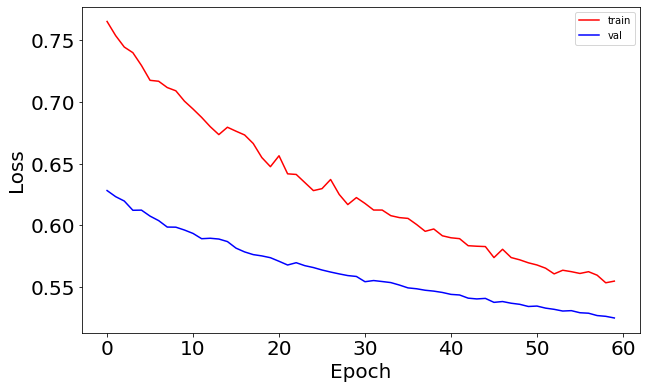

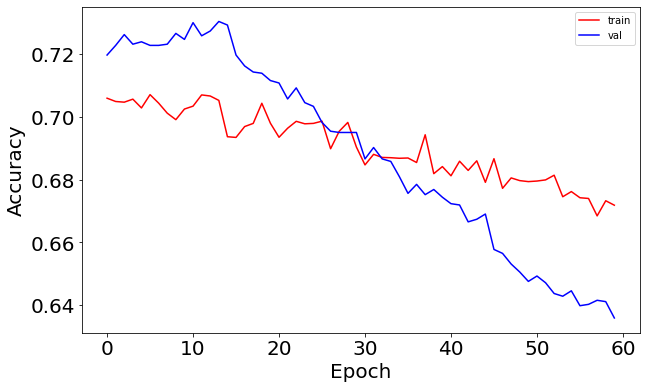

In [80]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [83]:
# solution
epochs = 60
learning_rate = 0.1 # initial learning rate
decay_rate = 0.1
momentum = 0.8

# define the optimizer function
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

input_dim = X_train.shape[1]
num_classes = 2
batch_size = 196

# build the model
exponential_decay_model = Sequential()
exponential_decay_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', input_dim = input_dim))
exponential_decay_model.add(Dropout(0.1))
exponential_decay_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
exponential_decay_model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

# compile the model
exponential_decay_model.compile(loss='categorical_crossentropy', 
                                optimizer=sgd, 
                                metrics=['acc'])
                                
# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate
    
# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]

# you invoke the LearningRateScheduler during the .fit() phase
exponential_decay_model_history = exponential_decay_model.fit(X_train, y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    verbose=1,
                                    validation_data=(X_test, y_test))

Epoch 1/60
83/83 [==============================] - 1s 4ms/step - loss: 99483480.0000 - acc: 0.4170 - val_loss: 0.3206 - val_acc: 0.4504 - lr: 0.1000
Epoch 2/60
83/83 [==============================] - 0s 3ms/step - loss: 1594934.5000 - acc: 0.4221 - val_loss: 163.0740 - val_acc: 0.3789 - lr: 0.0905
Epoch 3/60
83/83 [==============================] - 0s 2ms/step - loss: 736820.9375 - acc: 0.3859 - val_loss: 356.9364 - val_acc: 0.3789 - lr: 0.0819
Epoch 4/60
83/83 [==============================] - 0s 4ms/step - loss: 288.4561 - acc: 0.3845 - val_loss: 134.0808 - val_acc: 0.3789 - lr: 0.0741
Epoch 5/60
83/83 [==============================] - 0s 3ms/step - loss: 19.2252 - acc: 0.4525 - val_loss: 1.7778 - val_acc: 0.3789 - lr: 0.0670
Epoch 6/60
83/83 [==============================] - 0s 3ms/step - loss: 4.0761 - acc: 0.4693 - val_loss: 0.2545 - val_acc: 0.3789 - lr: 0.0607
Epoch 7/60
83/83 [==============================] - 0s 2ms/step - loss: 6.3303 - acc: 0.4701 - val_loss: 3.9683 - v

83/83 [==============================] - 0s 3ms/step - loss: 0.2775 - acc: 0.3845 - val_loss: 0.2834 - val_acc: 0.3789 - lr: 3.6979e-04
Epoch 58/60
83/83 [==============================] - 0s 2ms/step - loss: 0.2775 - acc: 0.3845 - val_loss: 0.2754 - val_acc: 0.3789 - lr: 3.3460e-04
Epoch 59/60
83/83 [==============================] - 0s 2ms/step - loss: 0.2779 - acc: 0.3845 - val_loss: 0.2744 - val_acc: 0.3789 - lr: 3.0276e-04
Epoch 60/60
83/83 [==============================] - 0s 2ms/step - loss: 0.2775 - acc: 0.3845 - val_loss: 0.2787 - val_acc: 0.3789 - lr: 2.7394e-04


In [85]:
# build the model
input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', 
                input_dim = input_dim)) # fully-connected layer with 64 hidden units
model.add(Dropout(0.1))
model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

# defining the parameters for RMSprop (I used the keras defaults here)
rms = RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=rms,
              metrics=['acc'])

In [86]:
%%time
batch_size = input_dim
epochs = 60

model_history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/60
397/397 [==============================] - 1s 2ms/step - loss: 0.5103 - acc: 0.4333 - val_loss: 0.2980 - val_acc: 0.3789
Epoch 2/60
397/397 [==============================] - 1s 2ms/step - loss: 2.7519 - acc: 0.4703 - val_loss: 4.9328 - val_acc: 0.3789
Epoch 3/60
397/397 [==============================] - 1s 2ms/step - loss: 7.0341 - acc: 0.4806 - val_loss: 38.7778 - val_acc: 0.6211
Epoch 4/60
397/397 [==============================] - 1s 2ms/step - loss: 13.5739 - acc: 0.4764 - val_loss: 11.4739 - val_acc: 0.3789
Epoch 5/60
397/397 [==============================] - 1s 1ms/step - loss: 22.6418 - acc: 0.4676 - val_loss: 7.0413 - val_acc: 0.3789
Epoch 6/60
397/397 [==============================] - 1s 2ms/step - loss: 32.3499 - acc: 0.4674 - val_loss: 47.4505 - val_acc: 0.3789
Epoch 7/60
397/397 [==============================] - 1s 1ms/step - loss: 46.0869 - acc: 0.4682 - val_loss: 182.5694 - val_acc: 0.6211
Epoch 8/60
397/397 [==============================] - 1s 2ms/step -

397/397 [==============================] - 1s 2ms/step - loss: 3788.0925 - acc: 0.4679 - val_loss: 2673.3740 - val_acc: 0.3789
CPU times: user 51.9 s, sys: 5.97 s, total: 57.9 s
Wall time: 46.2 s


Test loss: 2673.43603515625
Test accuracy: 0.378947377204895


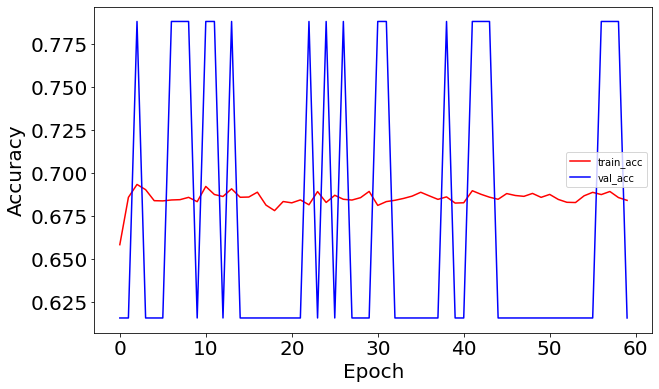

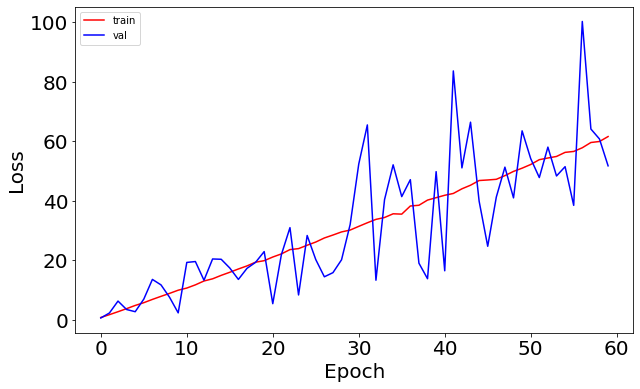

In [88]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['acc']), 'r', label='train_acc')
ax.plot(np.sqrt(model_history.history['val_acc']), 'b' ,label='val_acc')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)